# LSTM + Embedding
basé sur le kernel "https://www.kaggle.com/latong/lstm-vs-bert-train-data-from-scratch-huggingface/output" modifié pour fonctionner sur Keras

In [30]:
## Imports Absolus
import argparse
import os
import string
from numpy import array, argmax, random, take
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import emoji
import itertools
import nltk
import collections
from collections import Counter
from tokenizers.processors import BertProcessing
from tokenizers import (ByteLevelBPETokenizer,
                            CharBPETokenizer,
                            SentencePieceBPETokenizer,
                            BertWordPieceTokenizer)
# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

In [77]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [32]:
def lower_case(text):
    lower_text = text.lower()
    return lower_text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_nb(text):
    return ''.join([i for i in text if not i.isdigit()])



train['text']=train['text'].apply(lambda x : lower_case(x))
test['text']=test['text'].apply(lambda x : lower_case(x))
train['text']=train['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))
train['text']=train['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))
train['text']=train['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))
train['text']=train['text'].apply(lambda x : remove_nb(x))
test['text']=test['text'].apply(lambda x : remove_nb(x))

In [33]:
def remove_contractions(text):
    return contractions[str(text).lower()] if str(text).lower() in contractions.keys() else str(text)

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

In [34]:
# clean dataset
def clean_dataset(text):
    # To lowercase
    text = str(text).lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Insert space between words and punctuation marks
    text = re.sub(r'([\w\d]+)([^\w\d ]+)', '\1 \2',text)
    text = re.sub(r'([^\w\d ]+)([\w\d]+)', '\1 \2',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove punctuation
    text = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", text).split())
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [35]:
#remove stop word i.e. the most frequently appeared words 
myOwnStopList=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'what','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'do', 'should', "should", 'now', 'd', 'm', 'o', 're', 've', 'y', 'ain', "are", 'could', "was",
'would','have','get','got','getting','one','two','still','going']

In [36]:
train['text']=train['text'].apply(remove_contractions)
train['text']=train['text'].apply(clean_dataset)
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))
test['text']=test['text'].apply(remove_contractions)
test['text']=test['text'].apply(clean_dataset)
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (myOwnStopList)]))

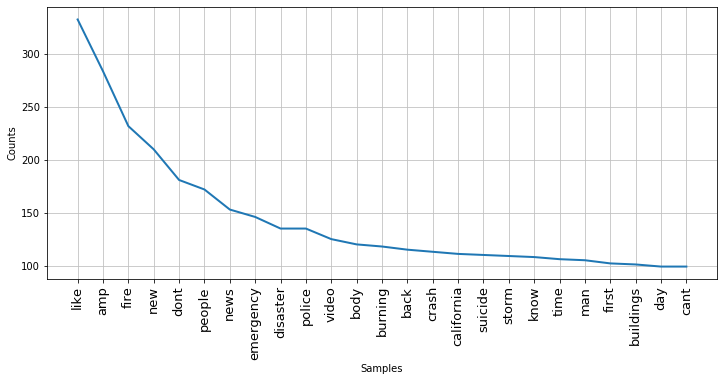

In [37]:
# most common words in twitter dataset 
all_texts = []
for line in list(train['text']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_texts)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_texts).values(), reverse=True)

In [38]:
len(train['text'].tolist()+test['text'].tolist())

10876

In [39]:
clean_text_list = train['text'].tolist()+test['text'].tolist()

In [40]:
train.to_csv("new_cleaned_train.csv",sep="*")
test.to_csv("new_cleaned_test.csv",sep="*")

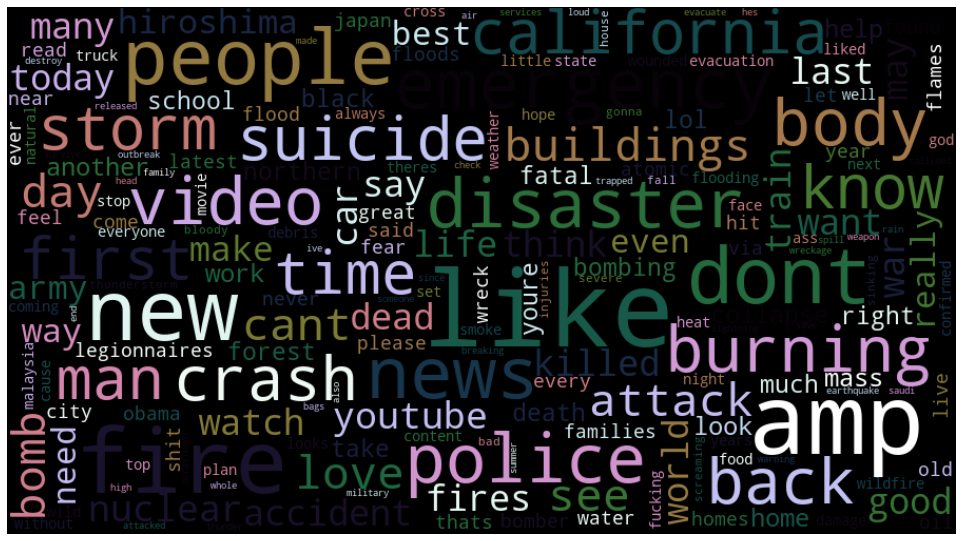

In [41]:

from wordcloud import WordCloud
# create a word frequency dictionary
wordfreq = Counter(all_texts)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [42]:
toBeCleanedNew='[%s]' % ' '.join(map(str, all_texts))#remove all the quation marks and commas.
vocab_size = int((1.5)*len(wordfreq))#the whole vocabulary size in train dataset

In [43]:
clean_text_list_to_write = [L + " \n" for L in clean_text_list]

In [44]:
clean_text_list_to_write_2 = []
for L in clean_text_list:
    clean_text_list_to_write_2.append(L)
    clean_text_list_to_write_2.append(" ")    

In [45]:
file1 = open("for_tokenizer.txt","w+") 
for L in clean_text_list_to_write_2:   
    file1.write(L)

In [46]:
file2 = open("for_tokenizer.txt","r+")  

In [47]:
file2.readline() 

'deeds reason earthquake may allah forgive forest fire near ronge sask canada residents asked shelter place notified officers evacuation shelter place orders expected people receive wildfires evacuation orders california sent photo ruby alaska smoke wildfires pours school rockyfire updatecalifornia hwyclosed directions due lake county firecafire wildfires flood disaster heavy rain causes flash flooding streets manitou colorado springs areas top hill see fire woods theres emergency evacuation happening building across street afraid tornado coming area three people died heat wave far haha south tampa flooded hah wait second live south tampa gonna gonna fvck flooding raining flooding florida tampabay tampaordays ive lost count flood bago myanmar arrived bago damage school bus onin multi car crash breaking whats man love fruits summer lovely car fast gooaal ridiculous london cool love skiing wonderful day lool wayi cant eat shit nyc last week love girlfriend cool like pasta end bbcmtd whol

In [48]:
train=train[['text','target']]
test=test[['id','text']]

In [49]:
tokenizer = BertWordPieceTokenizer()
tokenizer.enable_truncation(max_length=512)
tokenizer.train(files="for_tokenizer.txt", vocab_size=15_000, min_frequency=2)

In [50]:
from sklearn.model_selection import train_test_split
x_sub_train, x_sub_test, y_sub_train, y_sub_test = train_test_split(train['text'],train['target'], test_size=0.2, random_state=42)

In [51]:
text_train = train['text']
text_train_tokened=text_train.apply(lambda x:tokenizer.encode(x).ids)
text_train_tokened_pad = keras.preprocessing.sequence.pad_sequences(text_train_tokened, maxlen=max_len)

In [52]:
x_sub_train_tokened=x_sub_train.apply(lambda x:tokenizer.encode(x).ids)
x_sub_test_tokened=x_sub_test.apply(lambda x:tokenizer.encode(x).ids)

In [53]:
import keras
max_len=30
x_sub_train_tokened_pad = keras.preprocessing.sequence.pad_sequences(x_sub_train_tokened, maxlen=max_len)
x_sub_test_tokened_pad = keras.preprocessing.sequence.pad_sequences(x_sub_test_tokened, maxlen=max_len)

In [54]:
x_sub_test_tokened_pad.shape

(1523, 30)

In [55]:
x_sub_train_tokened_pad

array([[    0,     0,     0, ...,  1032, 10095,  9933],
       [    0,     0,     0, ...,  5998,  9399,    39],
       [    0,     0,     0, ...,  5654,  1131,   202],
       ...,
       [    0,     0,     0, ...,  2418,  5880,    39],
       [    0,     0,     0, ...,  7220,  6720,    39],
       [    0,     0,     0, ...,   556,  1551,   425]])

In [56]:
checkpoint = ModelCheckpoint("model_birectional_lstm_1", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint("model_birectional_lstm_2", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint("model_lstm_simple", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [57]:
embedding_dim=128
max_len=30
vocab_size = int((1.2)*len(wordfreq))
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(24, activation='relu'))
model.add(Dense(1))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()#

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 128)           2737408   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 64)            41216     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 30, 32)            10368     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total para

In [128]:
history=model.fit(x_sub_train_tokened_pad, y_sub_train,
          batch_size=24,
          epochs=10,
          validation_data=[x_sub_test_tokened_pad, y_sub_test],
          callbacks=[checkpoint]) 

Train on 6090 samples, validate on 1523 samples
Epoch 1/10


5112/6090 [========================>.....] - ETA: 2:51 - loss: 0.0268 - acc: 1.000 - ETA: 1:50 - loss: 0.0467 - acc: 0.958 - ETA: 1:24 - loss: 0.0387 - acc: 0.972 - ETA: 1:11 - loss: 0.0344 - acc: 0.979 - ETA: 1:04 - loss: 0.0501 - acc: 0.966 - ETA: 59s - loss: 0.0418 - acc: 0.972 - ETA: 55s - loss: 0.0431 - acc: 0.97 - ETA: 50s - loss: 0.0400 - acc: 0.97 - ETA: 47s - loss: 0.0384 - acc: 0.97 - ETA: 44s - loss: 0.0368 - acc: 0.97 - ETA: 42s - loss: 0.0367 - acc: 0.97 - ETA: 40s - loss: 0.0364 - acc: 0.97 - ETA: 38s - loss: 0.0395 - acc: 0.97 - ETA: 36s - loss: 0.0392 - acc: 0.97 - ETA: 35s - loss: 0.0366 - acc: 0.97 - ETA: 34s - loss: 0.0358 - acc: 0.97 - ETA: 33s - loss: 0.0338 - acc: 0.97 - ETA: 32s - loss: 0.0324 - acc: 0.97 - ETA: 31s - loss: 0.0345 - acc: 0.97 - ETA: 30s - loss: 0.0361 - acc: 0.97 - ETA: 30s - loss: 0.0365 - acc: 0.97 - ETA: 30s - loss: 0.0400 - acc: 0.97 - ETA: 29s - loss: 0.0394 - acc: 0.97 - ETA: 29s - loss: 0.0378 - acc: 0.97 - ETA: 28s - loss: 0.0378 - acc: 0

6090/6090 [==============================] - ETA: 3s - loss: 0.0278 - acc: 0.988 - ETA: 3s - loss: 0.0279 - acc: 0.988 - ETA: 3s - loss: 0.0278 - acc: 0.988 - ETA: 3s - loss: 0.0278 - acc: 0.987 - ETA: 3s - loss: 0.0277 - acc: 0.988 - ETA: 3s - loss: 0.0276 - acc: 0.988 - ETA: 3s - loss: 0.0274 - acc: 0.988 - ETA: 3s - loss: 0.0273 - acc: 0.988 - ETA: 3s - loss: 0.0272 - acc: 0.988 - ETA: 2s - loss: 0.0271 - acc: 0.988 - ETA: 2s - loss: 0.0270 - acc: 0.988 - ETA: 2s - loss: 0.0269 - acc: 0.988 - ETA: 2s - loss: 0.0270 - acc: 0.988 - ETA: 2s - loss: 0.0269 - acc: 0.988 - ETA: 2s - loss: 0.0271 - acc: 0.987 - ETA: 2s - loss: 0.0270 - acc: 0.988 - ETA: 2s - loss: 0.0269 - acc: 0.988 - ETA: 2s - loss: 0.0269 - acc: 0.987 - ETA: 2s - loss: 0.0268 - acc: 0.988 - ETA: 1s - loss: 0.0267 - acc: 0.988 - ETA: 1s - loss: 0.0266 - acc: 0.988 - ETA: 1s - loss: 0.0265 - acc: 0.988 - ETA: 1s - loss: 0.0264 - acc: 0.988 - ETA: 1s - loss: 0.0265 - acc: 0.988 - ETA: 1s - loss: 0.0264 - acc: 0.988 - ETA: 

5160/6090 [========================>.....] - ETA: 29s - loss: 0.0236 - acc: 1.00 - ETA: 23s - loss: 0.0121 - acc: 1.00 - ETA: 21s - loss: 0.0082 - acc: 1.00 - ETA: 20s - loss: 0.0061 - acc: 1.00 - ETA: 23s - loss: 0.0050 - acc: 1.00 - ETA: 24s - loss: 0.0115 - acc: 1.00 - ETA: 23s - loss: 0.0143 - acc: 0.99 - ETA: 24s - loss: 0.0178 - acc: 0.98 - ETA: 24s - loss: 0.0158 - acc: 0.99 - ETA: 24s - loss: 0.0197 - acc: 0.98 - ETA: 24s - loss: 0.0179 - acc: 0.98 - ETA: 23s - loss: 0.0164 - acc: 0.98 - ETA: 23s - loss: 0.0152 - acc: 0.99 - ETA: 22s - loss: 0.0148 - acc: 0.99 - ETA: 22s - loss: 0.0188 - acc: 0.98 - ETA: 23s - loss: 0.0207 - acc: 0.98 - ETA: 22s - loss: 0.0196 - acc: 0.98 - ETA: 22s - loss: 0.0209 - acc: 0.98 - ETA: 21s - loss: 0.0208 - acc: 0.98 - ETA: 21s - loss: 0.0213 - acc: 0.98 - ETA: 21s - loss: 0.0214 - acc: 0.98 - ETA: 20s - loss: 0.0227 - acc: 0.98 - ETA: 20s - loss: 0.0237 - acc: 0.98 - ETA: 20s - loss: 0.0234 - acc: 0.98 - ETA: 20s - loss: 0.0252 - acc: 0.98 - ETA: 

6090/6090 [==============================] - ETA: 3s - loss: 0.0235 - acc: 0.987 - ETA: 3s - loss: 0.0234 - acc: 0.987 - ETA: 3s - loss: 0.0237 - acc: 0.987 - ETA: 3s - loss: 0.0236 - acc: 0.987 - ETA: 3s - loss: 0.0235 - acc: 0.987 - ETA: 3s - loss: 0.0234 - acc: 0.987 - ETA: 3s - loss: 0.0235 - acc: 0.987 - ETA: 2s - loss: 0.0236 - acc: 0.987 - ETA: 2s - loss: 0.0236 - acc: 0.987 - ETA: 2s - loss: 0.0235 - acc: 0.987 - ETA: 2s - loss: 0.0234 - acc: 0.987 - ETA: 2s - loss: 0.0234 - acc: 0.987 - ETA: 2s - loss: 0.0233 - acc: 0.987 - ETA: 2s - loss: 0.0233 - acc: 0.987 - ETA: 2s - loss: 0.0232 - acc: 0.987 - ETA: 2s - loss: 0.0232 - acc: 0.987 - ETA: 2s - loss: 0.0232 - acc: 0.987 - ETA: 1s - loss: 0.0231 - acc: 0.987 - ETA: 1s - loss: 0.0230 - acc: 0.987 - ETA: 1s - loss: 0.0229 - acc: 0.987 - ETA: 1s - loss: 0.0228 - acc: 0.987 - ETA: 1s - loss: 0.0229 - acc: 0.987 - ETA: 1s - loss: 0.0229 - acc: 0.987 - ETA: 1s - loss: 0.0228 - acc: 0.987 - ETA: 1s - loss: 0.0227 - acc: 0.987 - ETA: 

5160/6090 [========================>.....] - ETA: 14s - loss: 0.0287 - acc: 1.00 - ETA: 19s - loss: 0.0322 - acc: 0.97 - ETA: 20s - loss: 0.0215 - acc: 0.98 - ETA: 20s - loss: 0.0162 - acc: 0.98 - ETA: 20s - loss: 0.0238 - acc: 0.98 - ETA: 20s - loss: 0.0295 - acc: 0.97 - ETA: 20s - loss: 0.0279 - acc: 0.98 - ETA: 19s - loss: 0.0297 - acc: 0.98 - ETA: 19s - loss: 0.0264 - acc: 0.98 - ETA: 19s - loss: 0.0263 - acc: 0.98 - ETA: 19s - loss: 0.0262 - acc: 0.98 - ETA: 19s - loss: 0.0311 - acc: 0.98 - ETA: 19s - loss: 0.0324 - acc: 0.98 - ETA: 19s - loss: 0.0301 - acc: 0.98 - ETA: 18s - loss: 0.0281 - acc: 0.98 - ETA: 18s - loss: 0.0330 - acc: 0.97 - ETA: 19s - loss: 0.0332 - acc: 0.97 - ETA: 19s - loss: 0.0329 - acc: 0.97 - ETA: 19s - loss: 0.0315 - acc: 0.98 - ETA: 19s - loss: 0.0314 - acc: 0.97 - ETA: 19s - loss: 0.0299 - acc: 0.98 - ETA: 19s - loss: 0.0294 - acc: 0.98 - ETA: 19s - loss: 0.0291 - acc: 0.98 - ETA: 19s - loss: 0.0297 - acc: 0.98 - ETA: 19s - loss: 0.0300 - acc: 0.98 - ETA: 

6090/6090 [==============================] - ETA: 3s - loss: 0.0231 - acc: 0.987 - ETA: 3s - loss: 0.0231 - acc: 0.987 - ETA: 3s - loss: 0.0233 - acc: 0.987 - ETA: 2s - loss: 0.0232 - acc: 0.987 - ETA: 2s - loss: 0.0231 - acc: 0.987 - ETA: 2s - loss: 0.0232 - acc: 0.987 - ETA: 2s - loss: 0.0231 - acc: 0.987 - ETA: 2s - loss: 0.0230 - acc: 0.987 - ETA: 2s - loss: 0.0230 - acc: 0.987 - ETA: 2s - loss: 0.0230 - acc: 0.987 - ETA: 2s - loss: 0.0229 - acc: 0.987 - ETA: 2s - loss: 0.0228 - acc: 0.987 - ETA: 2s - loss: 0.0227 - acc: 0.987 - ETA: 2s - loss: 0.0226 - acc: 0.988 - ETA: 2s - loss: 0.0226 - acc: 0.988 - ETA: 1s - loss: 0.0228 - acc: 0.987 - ETA: 1s - loss: 0.0229 - acc: 0.987 - ETA: 1s - loss: 0.0230 - acc: 0.987 - ETA: 1s - loss: 0.0230 - acc: 0.987 - ETA: 1s - loss: 0.0231 - acc: 0.987 - ETA: 1s - loss: 0.0233 - acc: 0.987 - ETA: 1s - loss: 0.0235 - acc: 0.987 - ETA: 1s - loss: 0.0234 - acc: 0.987 - ETA: 1s - loss: 0.0233 - acc: 0.987 - ETA: 1s - loss: 0.0234 - acc: 0.987 - ETA: 

4536/6090 [=====================>........] - ETA: 23s - loss: 0.0275 - acc: 1.00 - ETA: 20s - loss: 0.0140 - acc: 1.00 - ETA: 21s - loss: 0.0162 - acc: 1.00 - ETA: 20s - loss: 0.0122 - acc: 1.00 - ETA: 20s - loss: 0.0097 - acc: 1.00 - ETA: 18s - loss: 0.0107 - acc: 1.00 - ETA: 18s - loss: 0.0117 - acc: 1.00 - ETA: 18s - loss: 0.0136 - acc: 1.00 - ETA: 18s - loss: 0.0121 - acc: 1.00 - ETA: 18s - loss: 0.0158 - acc: 0.99 - ETA: 17s - loss: 0.0155 - acc: 0.99 - ETA: 17s - loss: 0.0149 - acc: 0.99 - ETA: 17s - loss: 0.0160 - acc: 0.99 - ETA: 16s - loss: 0.0169 - acc: 0.99 - ETA: 16s - loss: 0.0190 - acc: 0.99 - ETA: 16s - loss: 0.0254 - acc: 0.98 - ETA: 16s - loss: 0.0239 - acc: 0.99 - ETA: 16s - loss: 0.0241 - acc: 0.99 - ETA: 16s - loss: 0.0240 - acc: 0.99 - ETA: 16s - loss: 0.0254 - acc: 0.99 - ETA: 16s - loss: 0.0251 - acc: 0.99 - ETA: 16s - loss: 0.0269 - acc: 0.99 - ETA: 16s - loss: 0.0258 - acc: 0.99 - ETA: 16s - loss: 0.0247 - acc: 0.99 - ETA: 16s - loss: 0.0237 - acc: 0.99 - ETA: 

KeyboardInterrupt: 

In [ ]:
model.layers

In [129]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','validation'])
plt.savefig("history_accuracy_lstm.jpg")
plt.close()

In [130]:
test_file = pd.read_csv('test.csv')
test_file["Tokened_Text"]=test_file["text"].apply(lambda x:tokenizer.encode(x).ids)
test_file.head()
train_file = pd.read_csv('train.csv')
train_file["Tokened_Text"]=train_file["text"].apply(lambda x:tokenizer.encode(x).ids)
train_file.head()

,id,keyword,location,text,target,Tokened_Text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[7706, 32, 12764, 1050, 576, 2111, 1423, 5011,..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[695, 217, 489, 2040, 3783, 387, 268, 4940, 1,..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[1028, 3964, 3546, 1132, 1, 5260, 105, 2012, 1..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[1, 1, 1, 317, 10813, 1, 2990, 1030, 3909, 105..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[1480, 7636, 2518, 5011, 1163, 4707, 10293, 1,..."


In [131]:
test=keras.preprocessing.sequence.pad_sequences(test_file['Tokened_Text'], maxlen=max_len)
train=keras.preprocessing.sequence.pad_sequences(train_file['Tokened_Text'], maxlen=max_len)

In [132]:
submission=pd.read_csv('sample_submission.csv')

In [143]:
len(layer_output_train)

7613

In [146]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
layer_output_test = get_last_layer_output([test])[0].reshape(3263)
layer_output_train = get_last_layer_output([train])[0].reshape(7613)
submission=pd.DataFrame({'id':submission['id'].values.tolist(),'target':layer_output_test})
submission.to_csv('submission_test.csv',index=False)

In [147]:

train = pd.read_csv('train.csv')
train=pd.DataFrame({'id':train['id'].values.tolist(),'target':layer_output_train})
train.to_csv('submission_train.csv',index=False)

In [135]:
from keras import backend as K
get_last_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layer_output_test = get_last_layer_output([test])[0]
layer_output_train = get_last_layer_output([train])[0]

In [136]:
list(layer_output_train[:50])

[array([0.9995125], dtype=float32),
 array([0.9999363], dtype=float32),
 array([0.000734], dtype=float32),
 array([0.99999917], dtype=float32),
 array([0.9999914], dtype=float32),
 array([0.9999999], dtype=float32),
 array([0.9999999], dtype=float32),
 array([0.9990555], dtype=float32),
 array([0.99996996], dtype=float32),
 array([0.99965286], dtype=float32),
 array([0.9999926], dtype=float32),
 array([0.6734764], dtype=float32),
 array([0.13054582], dtype=float32),
 array([0.9999952], dtype=float32),
 array([0.99999934], dtype=float32),
 array([0.01390755], dtype=float32),
 array([3.5762787e-07], dtype=float32),
 array([0.295721], dtype=float32),
 array([0.00076729], dtype=float32),
 array([0.24679464], dtype=float32),
 array([0.00788543], dtype=float32),
 array([0.00632542], dtype=float32),
 array([0.00010687], dtype=float32),
 array([0.00015137], dtype=float32),
 array([0.9347045], dtype=float32),
 array([0.18878686], dtype=float32),
 array([2.1517277e-05], dtype=float32),
 array([4

In [89]:
train = pd.read_csv('train.csv')
train[:50]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [138]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [139]:
df_ytest = pd.DataFrame({'real_target' : y_sub_test})

In [140]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

y_pre2=model.predict(x_sub_test_tokened_pad)
y_pre2=np.round(y_pre2).astype(int).reshape(1523) #size de du test
submission2=pd.DataFrame({'target':y_pre2})

predicted_classes = submission2.target
y_test = df_ytest.real_target

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)


 
 Scores


,scores
accuracy,0.728825
precision,0.680428
recall,0.685670
f1,0.683039


In [68]:
from keras.models import load_model
model = load_model('model_lstm_simple')